In [112]:
pip install yfinance

In [113]:
pip install pandas_ta

In [114]:
pip install tensorflow-addons

In [128]:
import yfinance as yf
import pandas_ta as ta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate, BatchNormalization, LeakyReLU, Flatten, GRU, LayerNormalization, GlobalAveragePooling1D
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
import tensorflow_addons as tfa #un repositorio de contribuciones de la comunidad.

#Sacamos el dataset.

Datos historicos de bitcoin de cada día.

In [129]:
BTC_Ticker = yf.Ticker("BTC-USD")
data = BTC_Ticker.history(period='max', interval = '1d')[['Close', 'Open', 'High', 'Low', 'Volume']]

In [130]:
data.shape

(3552, 5)

#Añadir indicadores técnicos.




https://www.alpharithms.com/calculate-macd-python-272222/

https://tradingstrategy.ai/docs/_modules/pandas_ta/momentum/willr.html


In [131]:
data['RSI_6'] = ta.rsi(data.Close, length = 6)
data['RSI_15'] = ta.rsi(data.Close, length = 15)
data['RSI_28'] = ta.rsi(data.Close, length = 28)
# Add SMA (Simple Moving Average)
data['SMA_5'] = ta.sma(data.Close, length = 5)
data['SMA_12'] = ta.sma(data.Close, length = 12)
data['SMA_25'] = ta.sma(data.Close, length = 25)
data['SMA_50'] = ta.sma(data.Close, length = 50)
data['SMA_100'] = ta.sma(data.Close, length = 100)
data['SMA_150'] = ta.sma(data.Close, length = 150)
data['SMA_200'] = ta.sma(data.Close, length = 200)
#Golden Cross.
#data['GC'] = data.ta.sma(50, append=True) > data.ta.sma(200, append=True) #Nos da un true o false dependiendo si el SMA de 50 es mayor al SMA de 200
#Exponential Moving Average.
data['EMA_5'] = ta.ema(data.Close, length = 5)
data['EMA_12'] = ta.ema(data.Close, length = 12)
data['EMA_25'] = ta.ema(data.Close, length = 25)
data['EMA_50'] = ta.ema(data.Close, length = 50)
data['EMA_100'] = ta.ema(data.Close, length = 100)
data['EMA_150'] = ta.ema(data.Close, length = 150)
data['EMA_200'] = ta.ema(data.Close, length = 200)
#Stochastic Oscillator
#data.ta.kdj(data.High, data.Low, data.Close) # kdj(high=None, low=None, close=None, length=None, signal=None, offset=None, **kwargs)
#data['STCD'] = ta.kst(data.Close, length = 14)
#Moving Average Convergence/Divergence
data.ta.macd(close = 'Close', fast = 12, slow = 26, signal = 9, append = True)
data.ta.macd(close = 'Close', fast = 40, slow = 80, signal = 30, append = True)
#Williams
data['WILL_14'] = ta.willr(data.High, data.Low, data.Close, 14)
data['WILL_28'] = ta.willr(data.High, data.Low, data.Close, 28)
data['WILL_50'] = ta.willr(data.High, data.Low, data.Close, 50)
data['WILL_100'] = ta.willr(data.High, data.Low, data.Close, 100)
#Momemtum Indicator
data['MOM_5'] = ta.mom(data.Close, length = 5)
data['MOM_10'] = ta.mom(data.Close, length = 10)
data['MOM_100'] = ta.mom(data.Close, length = 100)
data['MOM_200'] = ta.mom(data.Close, length = 200)
#Accumulation Distribution Index(A/D).
data['AD'] = ta.ad(data.High, data.Low, data.Close, data.Volume)
#Utilizes the relative position of the close to it's High-Low range with volume

data['Target'] = data['Close'] - data.Open # Diferencia de precios
data['Target'] = data['Target'].shift(-1)
data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))] # 1 si la diferencia es positiva, else 0.
data['TargetNextClose'] = data['Close'].shift(-1) # Target is the next day closing price.

#data.dropna(inplace = True)
data.drop(['Volume', 'Close'], axis=1, inplace=True) #Should I drop the date column?. I don't think the date will give us valuable information. We'll se in the feature selection step.

In [132]:
#data.ta.indicators()
#help(ta.mom)

Quitamos los datos nulos.

In [133]:
print(data.columns)
#data['TargetNextClose']
nan_counts_per_column = data.isna().sum()
print(nan_counts_per_column)
print(data.shape)

#Que tal si borro las primeras 199 filas, a ver cuanto reduzco los nulos.
data = data.drop(data.index[:200])
data = data.drop(data.index[-1])
nan_counts_per_column = data.isna().sum()
print("\nDespues de borrar las primeras 200 filas y la ultima\n", nan_counts_per_column)
print(data.shape)

Index(['Open', 'High', 'Low', 'RSI_6', 'RSI_15', 'RSI_28', 'SMA_5', 'SMA_12',
       'SMA_25', 'SMA_50', 'SMA_100', 'SMA_150', 'SMA_200', 'EMA_5', 'EMA_12',
       'EMA_25', 'EMA_50', 'EMA_100', 'EMA_150', 'EMA_200', 'MACD_12_26_9',
       'MACDh_12_26_9', 'MACDs_12_26_9', 'MACD_40_80_30', 'MACDh_40_80_30',
       'MACDs_40_80_30', 'WILL_14', 'WILL_28', 'WILL_50', 'WILL_100', 'MOM_5',
       'MOM_10', 'MOM_100', 'MOM_200', 'AD', 'Target', 'TargetClass',
       'TargetNextClose'],
      dtype='object')
Open                 0
High                 0
Low                  0
RSI_6                6
RSI_15              15
RSI_28              28
SMA_5                4
SMA_12              11
SMA_25              24
SMA_50              49
SMA_100             99
SMA_150            149
SMA_200            199
EMA_5                4
EMA_12              11
EMA_25              24
EMA_50              49
EMA_100             99
EMA_150            149
EMA_200            199
MACD_12_26_9        25
MACDh_12_2

In [134]:
# Display the DataFrame with the technical indicators
data

,Open,High,Low,RSI_6,RSI_15,RSI_28,SMA_5,SMA_12,SMA_25,SMA_50,...,WILL_50,WILL_100,MOM_5,MOM_10,MOM_100,MOM_200,AD,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,,,,,,,,,
2015-04-05 00:00:00+00:00,253.761002,260.674988,251.942001,65.657846,52.103138,50.359090,253.778802,249.826085,261.651041,259.639901,...,-54.513563,-43.400621,16.373993,12.065994,-67.326019,-196.736023,-2.169761e+08,-5.229004,0,255.492004
2015-04-06 00:00:00+00:00,260.721008,261.798004,254.574997,53.321380,48.765751,48.855430,255.422803,250.600669,260.096561,260.053241,...,-62.729858,-43.607851,8.220001,8.462997,-60.371002,-168.947998,-2.319234e+08,-2.094009,0,253.179993
2015-04-07 00:00:00+00:00,255.274002,255.804993,252.205002,48.381927,47.296010,48.179904,255.457800,250.988002,258.810281,260.439981,...,-69.192390,-45.160318,0.174988,0.381989,-64.059021,-141.615997,-2.403877e+08,-8.041992,0,245.022003
2015-04-08 00:00:00+00:00,253.063995,253.847000,244.214996,34.751142,42.458252,45.859590,253.597800,250.820751,257.335760,260.468221,...,-81.268455,-50.638236,-9.300003,2.309006,-67.648010,-163.881989,-2.654326e+08,-1.075012,0,243.675995
2015-04-09 00:00:00+00:00,244.751007,246.117996,239.399994,32.915115,41.704155,45.484784,251.593597,250.060584,255.627080,260.615221,...,-83.356270,-51.542052,-10.021011,-3.850006,-67.061005,-155.145020,-2.595240e+08,-7.621994,0,236.072006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-02 00:00:00+00:00,67710.273438,68409.164062,67315.523438,47.939429,53.196110,53.108005,67778.607813,68328.820964,66553.591250,64940.290078,...,-27.254978,-25.894953,-544.617188,-177.960938,17019.652344,29871.019531,4.960952e+12,1050.882812,1,68804.781250
2024-06-03 00:00:00+00:00,67753.898438,70230.820312,67589.835938,59.491144,56.210004,54.515083,68023.945312,68302.358073,66783.784062,65001.611172,...,-20.412224,-21.671767,1226.687500,278.679688,17233.679688,32650.011719,4.958362e+12,1763.195312,1,70567.765625
2024-06-04 00:00:00+00:00,68804.570312,71047.406250,68564.640625,71.980204,60.743815,56.767112,68464.500000,68522.208333,67174.783594,65144.442266,...,-8.957704,-13.945831,2202.773438,1301.820312,18834.527344,33971.082031,4.978704e+12,514.468750,1,71082.820312


Scaler

Scaled data to be between 0 and 1, so that we can fit into the neural network.

In [135]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)
#print(data_scaled)

#Phase 2.

###Prediction with different Neural Networks architectures:

Simple NN.

RNN.

LSTM.

Transformer.



X es un numpy array multidimensional que contiene las 3296 filas, con datos de los 30 dias previos(backcandles) de las 37 features.

In [136]:
X = []

backcandles = 15 # number of days to fit into the model to be able to make a prediction. Number of days to look back in order to make a prediction
print(data_scaled.shape[0], data_scaled.shape[1])

for j in range(data_scaled.shape[1]): #Recorremos las columnas
  X.append([])
  for i in range(backcandles, data_scaled.shape[0]): #Recorremos de desde la fila backcandles hasta que acabemos las filas.
    # Guardamos los 30 datos anteriores en este elemento lista(X[j]) de la lista de listas(X).
    X[j].append(data_scaled[i - backcandles:i, j]) # i - backcandles -> Los ultimos 30 dias hasta i.


#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(data_scaled[backcandles:, -1]) # Target = Next closing price.
#X, yi = np.array(X), np.array(data_scaled[backcandles:, -3]) # Target = Close - Open. Diferencia, el comportamiento real.
y = np.reshape(yi,(len(yi), 1))

#print(X)
#print(y)
print(X.shape)
print(y.shape)

3351 38
(3336, 15, 38)
(3336, 1)


In [137]:
splitlimit = int(len(X)*0.8)
print(splitlimit)

X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]

print(f"Total de datos: {len(X)}")
print(f"Datos de entrenamiento: {splitlimit} ({splitlimit/len(X)*100:.2f}%)")
print(f"Datos de prueba: {len(X) - splitlimit} ({(len(X) - splitlimit)/len(X)*100:.2f}%)\n")

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de y_test: {y_test.shape}\n")

print(f"Primeros 5 valores de y_train: {y_train[:5]}")
print(f"Primeros 5 valores de y_test: {y_test[:5]}")

2668
Total de datos: 3336
Datos de entrenamiento: 2668 (79.98%)
Datos de prueba: 668 (20.02%)

Forma de X_train: (2668, 15, 38)
Forma de X_test: (668, 15, 38)
Forma de y_train: (2668, 1)
Forma de y_test: (668, 1)

Primeros 5 valores de y_train: [[0.00033996]
 [0.00032496]
 [0.00035633]
 [0.00028506]
 [0.00021812]]
Primeros 5 valores de y_test: [[0.32573307]
 [0.32586874]
 [0.33197922]
 [0.33227082]
 [0.33083361]]


##LSTM

In [ ]:
def build_lstm_model(input_shape):
  lstm_input = Input(shape=(backcandles, data_scaled.shape[1]), name='lstm_input')

  lstm_layer_1 = LSTM(150, return_sequences=True, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), name='first_layer')(lstm_input) #150 nodes, return sequences?
  layer_norm_1 = LayerNormalization(name='layer_norm_1')(lstm_layer_1)
  dropout_layer_1 = Dropout(0.2, name='dropout_layer')(layer_norm_1)

  lstm_layer_2 = LSTM(100, return_sequences=True, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), name='second_layer')(dropout_layer_1) #100 nodes
  layer_norm_2 = LayerNormalization(name='layer_norm_2')(lstm_layer_2)
  dropout_layer_2 = Dropout(0.2, name='dropout_layer_2')(lstm_layer_2)

  lstm_layer_3 = LSTM(50, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), name='third_layer')(dropout_layer_2) #50 nodes
  layer_norm_3 = LayerNormalization(name='layer_norm_3')(lstm_layer_3)
  dropout_layer_3 = Dropout(0.2, name='dropout_layer_3')(lstm_layer_3)

  batch_norm_layer = BatchNormalization(name='batch_norm_layer')(dropout_layer_3)

  #dense = Dense(100, name='dense')(batch_norm_layer)
  dense_layer = Dense(1, name='dense_layer')(batch_norm_layer)
  output = LeakyReLU(alpha=0.2, name='output')(dense_layer)
  model = Model(inputs=lstm_input, outputs=output)
  model.compile(optimizer=Adam(), loss='mse', metrics=['mse', 'mae', 'mape', 'msle' ])
  return model

In [ ]:
lstm_model = build_lstm_model((backcandles, data_scaled.shape[1]))
lstm_model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

lstm_model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, callbacks=[early_stopping, reduce_lr], shuffle=True, validation_split=0.1)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 15, 38)]          0         
                                                                 
 first_layer (LSTM)          (None, 15, 150)           113400    
                                                                 
 layer_norm_1 (LayerNormali  (None, 15, 150)           300       
 zation)                                                         
                                                                 
 dropout_layer (Dropout)     (None, 15, 150)           0         
                                                                 
 second_layer (LSTM)         (None, 15, 100)           100400    
                                                                 
 dropout_layer_2 (Dropout)   (None, 15, 100)           0         
                                                           

In [ ]:
lstm_y_pred = lstm_model.predict(X_test)

for i in range(10):
  #print(lstm_y_pred[i], y_test[i])
  print(f'Predicción: {lstm_y_pred[i]}, Valor real: {y_test[i]}')

21/21 [==============================] - 2s 21ms/step
Predicción: [0.5177554], Valor real: [0.56131144]
Predicción: [0.51777714], Valor real: [0.50916812]
Predicción: [0.51774156], Valor real: [0.53851076]
Predicción: [0.5177042], Valor real: [0.5100218]
Predicción: [0.51769906], Valor real: [0.50117369]
Predicción: [0.5176897], Valor real: [0.49635838]
Predicción: [0.51767445], Valor real: [0.49222342]
Predicción: [0.5176618], Valor real: [0.47188725]
Predicción: [0.5176623], Valor real: [0.49992463]
Predicción: [0.517678], Valor real: [0.35151038]


In [ ]:
scaler_onedimension = MinMaxScaler(feature_range=(0,1))
target_scaled = scaler_onedimension.fit_transform(data["Target"].values.reshape(-1,1))
#inversing the scaler
lstm_y_pred_not_scaled = scaler_onedimension.inverse_transform(lstm_y_pred)
y_test_not_scaled = scaler_onedimension.inverse_transform(y_test)

for i in range(644,664):
  #print(lstm_y_pred[i], y_test[i])
  print(f'Predicción: {lstm_y_pred_not_scaled[i]}, Valor real: {y_test_not_scaled[i]}')

Predicción: [133.9535], Valor real: [4713.50390625]
Predicción: [131.74957], Valor real: [-1024.52734375]
Predicción: [134.3489], Valor real: [1820.578125]
Predicción: [135.04395], Valor real: [-125.40625]
Predicción: [135.38792], Valor real: [-659.5625]
Predicción: [134.79749], Valor real: [5169.453125]
Predicción: [133.60864], Valor real: [-1306.53125]
Predicción: [133.12193], Valor real: [-1012.984375]
Predicción: [132.77086], Valor real: [-1191.7421875]
Predicción: [133.30278], Valor real: [597.96875]
Predicción: [132.79922], Valor real: [739.0234375]
Predicción: [133.67691], Valor real: [-746.1953125]
Predicción: [133.8613], Valor real: [882.375]
Predicción: [134.09712], Valor real: [-1095.9765625]
Predicción: [133.75491], Valor real: [-718.2578125]
Predicción: [134.56345], Valor real: [788.90625]
Predicción: [134.73012], Valor real: [-871.1015625]
Predicción: [135.36664], Valor real: [217.328125]
Predicción: [135.33473], Valor real: [41.328125]
Predicción: [135.90211], Valor real

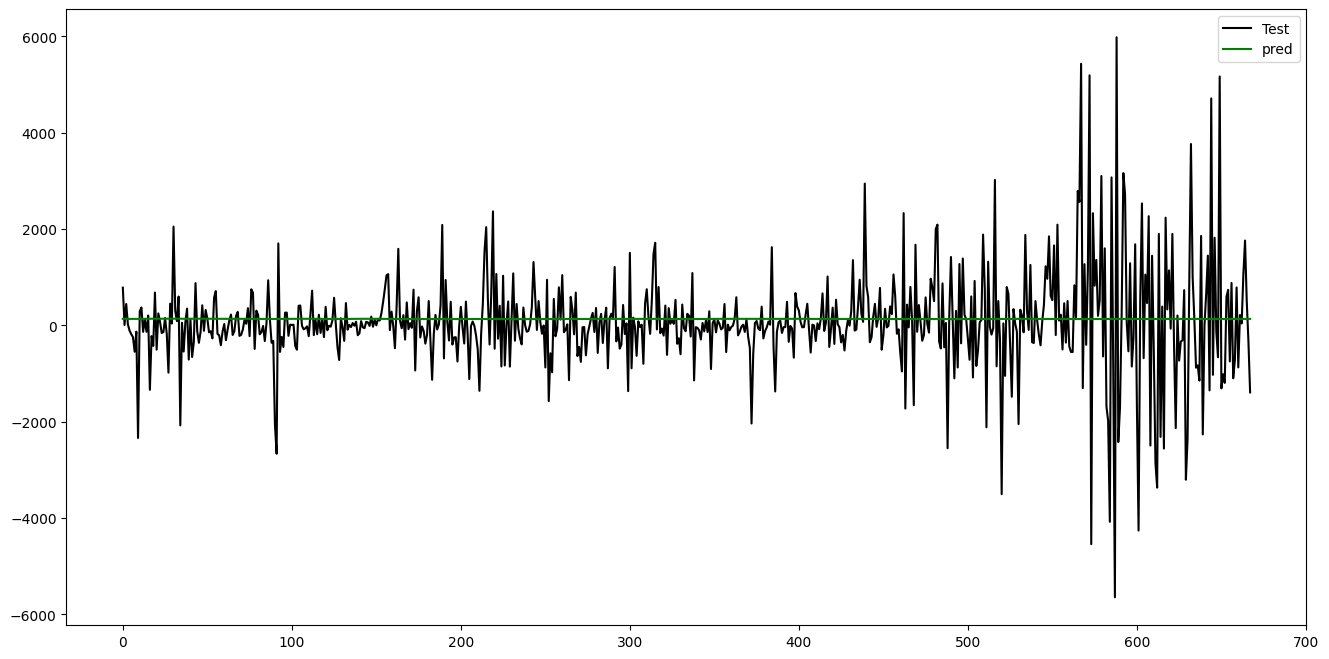

In [ ]:
plt.figure(figsize = (16,8))
plt.plot(y_test_not_scaled, color='black', label='Test')
plt.plot(lstm_y_pred_not_scaled, color='green', label='pred')
plt.legend()
plt.show()

##Neural Network

In [ ]:
def build_shallow_nn(input_shape):
    nn_input = Input(shape=input_shape, name='nn_input')
    flatten_layer = Flatten()(nn_input)
    hidden_layer = Dense(64, activation='relu', name='hidden_layer')(flatten_layer)
    output_layer = Dense(1, activation='linear', name='output_layer')(hidden_layer)
    model = Model(inputs=nn_input, outputs=output_layer)
    model.compile(optimizer=Adam(), loss='mse', metrics=['mse', 'mae', 'mape', 'msle'])
    return model

In [ ]:
nn_model = build_shallow_nn((backcandles, data_scaled.shape[1]))
nn_model.summary()
nn_model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split=0.1)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 nn_input (InputLayer)       [(None, 15, 38)]          0         
                                                                 
 flatten_2 (Flatten)         (None, 570)               0         
                                                                 
 hidden_layer (Dense)        (None, 64)                36544     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 36609 (143.00 KB)
Trainable params: 36609 (143.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
161/161 [==============================] - 1s 5ms/step - loss: 0.0250 - mse: 0.0250 - mae: 0.0939 - mape: 78337.7891 - msle: 0.0089 - val_loss

In [ ]:
nn_y_pred = nn_model.predict(X_test)

21/21 [==============================] - 0s 3ms/step


Predicción: [-788.74243], Valor real: [739.0234375]
Predicción: [-565.1271], Valor real: [-746.1953125]
Predicción: [-892.69604], Valor real: [882.375]
Predicción: [-1073.2296], Valor real: [-1095.9765625]
Predicción: [-728.49866], Valor real: [-718.2578125]
Predicción: [-791.7677], Valor real: [788.90625]
Predicción: [-1028.8345], Valor real: [-871.1015625]
Predicción: [-1277.8944], Valor real: [217.328125]
Predicción: [-1048.2063], Valor real: [41.328125]
Predicción: [-786.0642], Valor real: [1050.8828125]


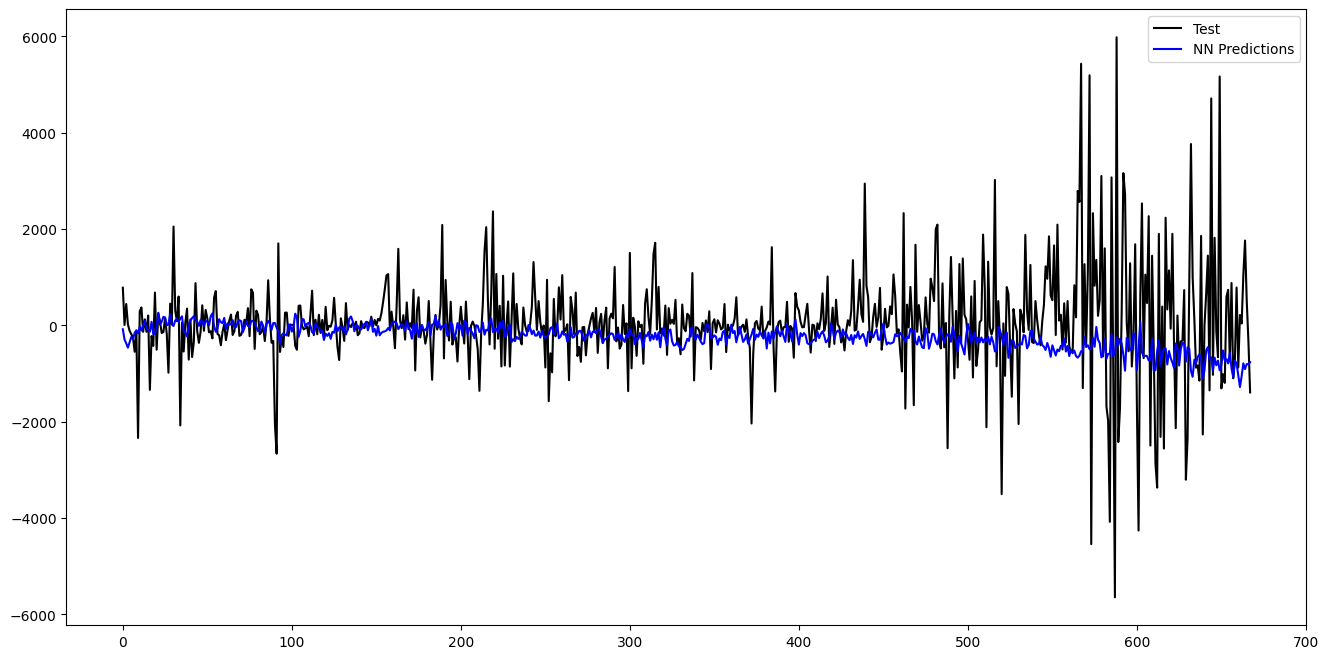

In [ ]:
#inversing the scaler
nn_y_pred_not_scaled = scaler_onedimension.inverse_transform(nn_y_pred)

for i in range(654,664):
  #print(lstm_y_pred[i], y_test[i])
  print(f'Predicción: {nn_y_pred_not_scaled[i]}, Valor real: {y_test_not_scaled[i]}')

plt.figure(figsize=(16, 8))
plt.plot(y_test_not_scaled, color='black', label='Test')
plt.plot(nn_y_pred_not_scaled, color='blue', label='NN Predictions')
plt.legend()
plt.show()

##Recurrent Neural Network

In [ ]:
def build_gru_model(input_shape):
    gru_input = Input(shape=input_shape, name='gru_input')
    gru_layer = GRU(150, name='gru_layer')(gru_input)
    dropout_layer = Dropout(0.2, name='dropout_layer')(gru_layer)
    output_layer = Dense(1, activation='linear', name='output_layer')(dropout_layer)
    model = Model(inputs=gru_input, outputs=output_layer)
    model.compile(optimizer=Adam(), loss='mse', metrics=['mse', 'mae', 'mape', 'msle'])
    return model

In [ ]:
gru_model = build_gru_model((backcandles, data_scaled.shape[1]))
gru_model.summary()
gru_model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split=0.1)

21/21 [==============================] - 1s 8ms/step


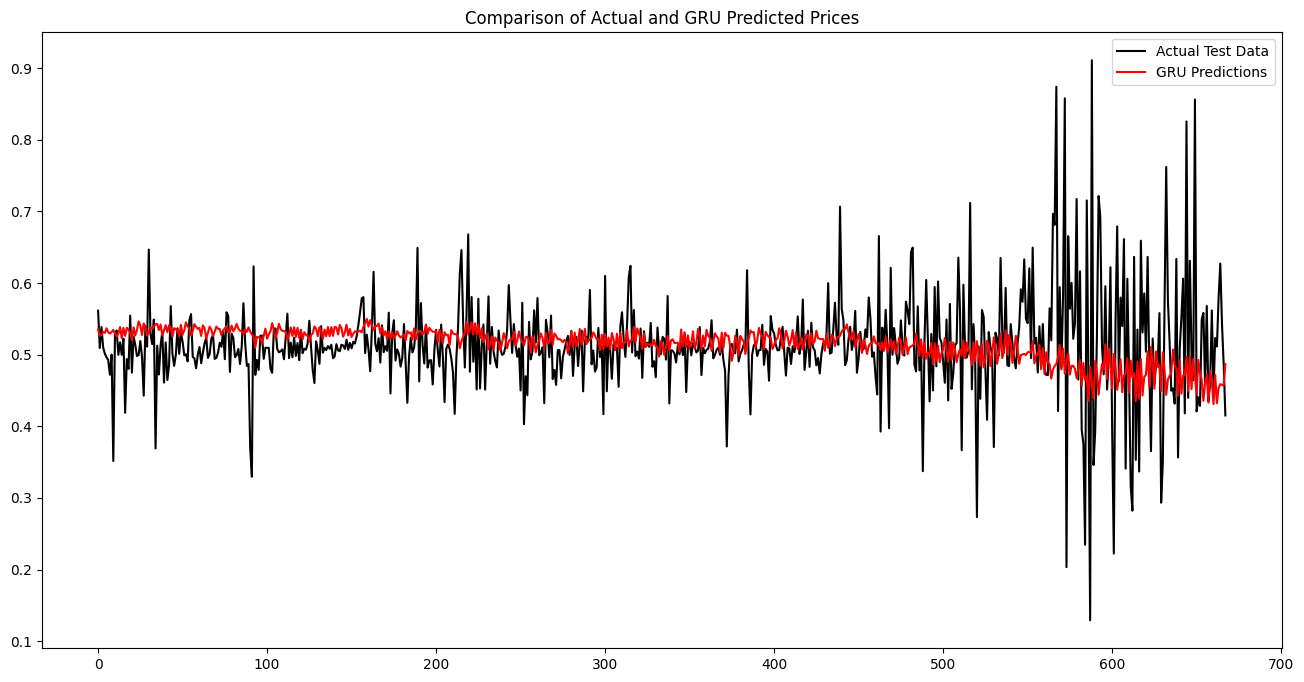

In [ ]:
gru_y_pred = gru_model.predict(X_test)

plt.figure(figsize=(16, 8))
plt.plot(y_test, color='black', label='Actual Test Data')
plt.plot(gru_y_pred, color='red', label='GRU Predictions')
plt.title('Comparison of Actual and GRU Predicted Prices')
plt.legend()
plt.show()


Transformer:

Apply a regression transformer architecture to predict, evaluate the predictions and plot the graph.

In [122]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim) #Atención de los transformers.
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs) #multi head attention.
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_transformer_model(input_shape, num_heads, ff_dim, embed_dim, num_blocks):
    inputs = Input(shape=(backcandles, data_scaled.shape[1]))
    x = Dense(embed_dim)(inputs) #Transformar la entrada al espacio embebido.
    for _ in range(num_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    x = GlobalAveragePooling1D()(x) #Pooling para reducir la dimensionalidad.
    x = Dropout(0.1)(x)
    x = Dense(20, activation="relu")(x)
    x = Dropout(0.1)(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Define parameters
num_heads = 8
ff_dim = 32
embed_dim = 64
num_blocks = 4

# Build and compile the model
transformer_model = build_transformer_model((X_train.shape[1], 1), num_heads, ff_dim, embed_dim, num_blocks)


In [123]:
history = transformer_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)
transformer_y_pred = transformer_model.predict(X_test)

Epoch 1/50
67/67 [==============================] - 20s 159ms/step - loss: 0.0874 - val_loss: 0.0135
Epoch 2/50
67/67 [==============================] - 8s 120ms/step - loss: 0.0110 - val_loss: 0.0132
Epoch 3/50
67/67 [==============================] - 9s 136ms/step - loss: 0.0093 - val_loss: 0.0122
Epoch 4/50
67/67 [==============================] - 9s 129ms/step - loss: 0.0084 - val_loss: 0.0123
Epoch 5/50
67/67 [==============================] - 8s 125ms/step - loss: 0.0074 - val_loss: 0.0122
Epoch 6/50
67/67 [==============================] - 10s 146ms/step - loss: 0.0076 - val_loss: 0.0122
Epoch 7/50
67/67 [==============================] - 7s 111ms/step - loss: 0.0067 - val_loss: 0.0125
Epoch 8/50
67/67 [==============================] - 12s 188ms/step - loss: 0.0065 - val_loss: 0.0125
Epoch 9/50
67/67 [==============================] - 8s 113ms/step - loss: 0.0065 - val_loss: 0.0123
Epoch 10/50
67/67 [==============================] - 10s 151ms/step - loss: 0.0059 - val_loss: 0.

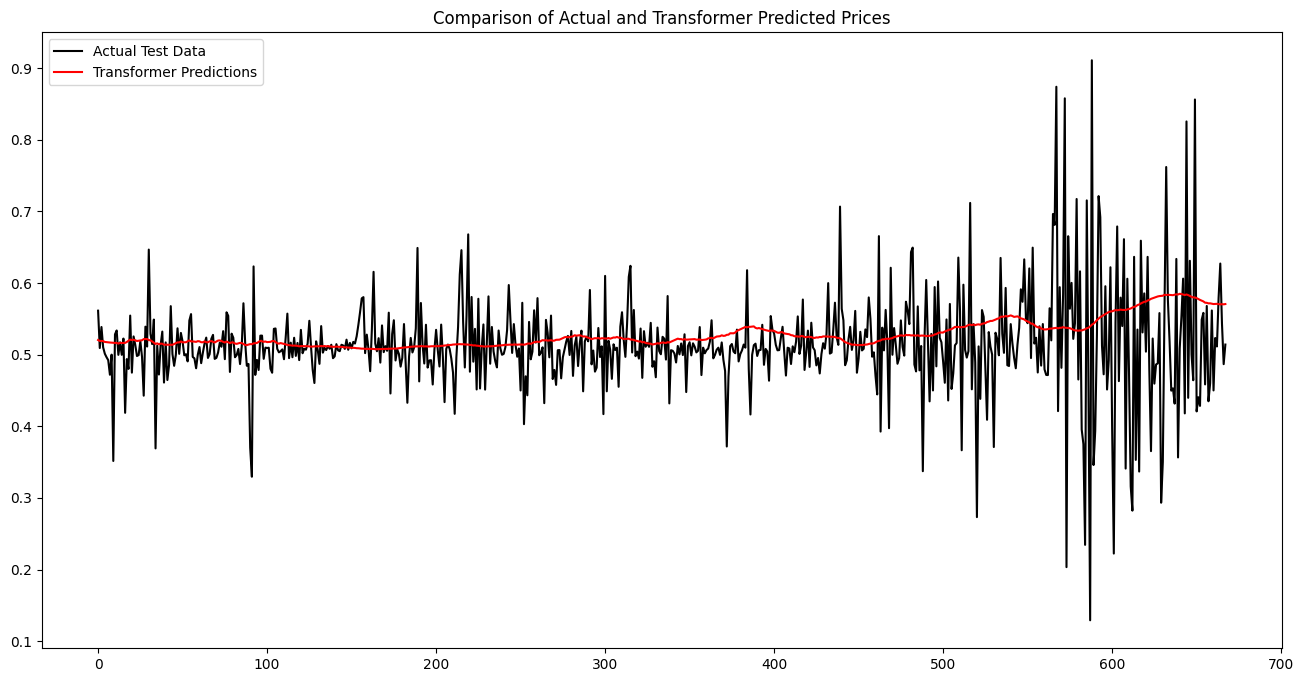

In [124]:
plt.figure(figsize=(16, 8))
plt.plot(y_test, color='black', label='Actual Test Data')
plt.plot(transformer_y_pred, color='red', label='Transformer Predictions')
plt.title('Comparison of Actual and Transformer Predicted Prices')
plt.legend()
plt.show()

In [127]:
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, mae, mape
transformer_metrics = calculate_metrics(y_test, transformer_y_pred.flatten())
print(transformer_metrics[0])
print(transformer_metrics[1])
print(transformer_metrics[2])

0.0053824305687137225
0.046028590782312605
0.10171234276695117


#Metrics

In [ ]:
# Calculate metrics

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, mae, mape

nn_metrics = calculate_metrics(y_test, nn_y_pred.flatten())
lstm_metrics = calculate_metrics(y_test, lstm_y_pred.flatten())
gru_metrics = calculate_metrics(y_test, gru_y_pred.flatten())
transformer_metrics = calculate_metrics(y_test, transformer_y_pred.flatten())


# Creating a DataFrame with the metrics
metrics_df = pd.DataFrame({
    'Model': ['Shallow NN', 'LSTM', 'GRU', 'Transformer'],
    'MSE': [nn_metrics[0], lstm_metrics[0], gru_metrics[0], transformer_metrics[0]],
    'MAE': [nn_metrics[1], lstm_metrics[1], gru_metrics[1], transformer_metrics[1]],
    'MAPE': [nn_metrics[2], lstm_metrics[2], gru_metrics[2], transformer_metrics[2]]
})


print(metrics_df)

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_test, color='black', label='Actual Test Data')
plt.plot(nn_y_pred, color='blue', label='Neural Network Predictions')
plt.plot(gru_y_pred, color='red', label='Gated Recurrent Neural Network Predictions')
plt.plot(lstm_y_pred, color='orange', label='LSTM Predictions')
plt.plot(transformer_y_pred, color='green', label='Transformer Predictions')
plt.title('Comparison of Actual and Transformer Predicted Prices')
plt.legend()
plt.show()

Arquitectura de paper with code.


PatchTST_layers

In [138]:
__all__ = ['Transpose', 'get_activation_fn', 'moving_avg', 'series_decomp', 'PositionalEncoding', 'SinCosPosEncoding', 'Coord2dPosEncoding', 'Coord1dPosEncoding', 'positional_encoding']

import torch
from torch import nn
import math

class Transpose(nn.Module):
    def __init__(self, *dims, contiguous=False):
        super().__init__()
        self.dims, self.contiguous = dims, contiguous
    def forward(self, x):
        if self.contiguous: return x.transpose(*self.dims).contiguous()
        else: return x.transpose(*self.dims)


def get_activation_fn(activation):
    if callable(activation): return activation()
    elif activation.lower() == "relu": return nn.ReLU()
    elif activation.lower() == "gelu": return nn.GELU()
    raise ValueError(f'{activation} is not available. You can use "relu", "gelu", or a callable')


# decomposition

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean



# pos_encoding

def PositionalEncoding(q_len, d_model, normalize=True):
    pe = torch.zeros(q_len, d_model)
    position = torch.arange(0, q_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    if normalize:
        pe = pe - pe.mean()
        pe = pe / (pe.std() * 10)
    return pe

SinCosPosEncoding = PositionalEncoding

def Coord2dPosEncoding(q_len, d_model, exponential=False, normalize=True, eps=1e-3, verbose=False):
    x = .5 if exponential else 1
    i = 0
    for i in range(100):
        cpe = 2 * (torch.linspace(0, 1, q_len).reshape(-1, 1) ** x) * (torch.linspace(0, 1, d_model).reshape(1, -1) ** x) - 1
        pv(f'{i:4.0f}  {x:5.3f}  {cpe.mean():+6.3f}', verbose)
        if abs(cpe.mean()) <= eps: break
        elif cpe.mean() > eps: x += .001
        else: x -= .001
        i += 1
    if normalize:
        cpe = cpe - cpe.mean()
        cpe = cpe / (cpe.std() * 10)
    return cpe

def Coord1dPosEncoding(q_len, exponential=False, normalize=True):
    cpe = (2 * (torch.linspace(0, 1, q_len).reshape(-1, 1)**(.5 if exponential else 1)) - 1)
    if normalize:
        cpe = cpe - cpe.mean()
        cpe = cpe / (cpe.std() * 10)
    return cpe

def positional_encoding(pe, learn_pe, q_len, d_model):
    # Positional encoding
    if pe == None:
        W_pos = torch.empty((q_len, d_model)) # pe = None and learn_pe = False can be used to measure impact of pe
        nn.init.uniform_(W_pos, -0.02, 0.02)
        learn_pe = False
    elif pe == 'zero':
        W_pos = torch.empty((q_len, 1))
        nn.init.uniform_(W_pos, -0.02, 0.02)
    elif pe == 'zeros':
        W_pos = torch.empty((q_len, d_model))
        nn.init.uniform_(W_pos, -0.02, 0.02)
    elif pe == 'normal' or pe == 'gauss':
        W_pos = torch.zeros((q_len, 1))
        torch.nn.init.normal_(W_pos, mean=0.0, std=0.1)
    elif pe == 'uniform':
        W_pos = torch.zeros((q_len, 1))
        nn.init.uniform_(W_pos, a=0.0, b=0.1)
    elif pe == 'lin1d': W_pos = Coord1dPosEncoding(q_len, exponential=False, normalize=True)
    elif pe == 'exp1d': W_pos = Coord1dPosEncoding(q_len, exponential=True, normalize=True)
    elif pe == 'lin2d': W_pos = Coord2dPosEncoding(q_len, d_model, exponential=False, normalize=True)
    elif pe == 'exp2d': W_pos = Coord2dPosEncoding(q_len, d_model, exponential=True, normalize=True)
    elif pe == 'sincos': W_pos = PositionalEncoding(q_len, d_model, normalize=True)
    else: raise ValueError(f"{pe} is not a valid pe (positional encoder. Available types: 'gauss'=='normal', \
        'zeros', 'zero', uniform', 'lin1d', 'exp1d', 'lin2d', 'exp2d', 'sincos', None.)")
    return nn.Parameter(W_pos, requires_grad=learn_pe)

RevIN

In [139]:
import torch
import torch.nn as nn

class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True, subtract_last=False):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        if self.affine:
            self._init_params()

    def forward(self, x, mode:str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else: raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        if self.subtract_last:
            self.last = x[:,-1,:].unsqueeze(1)
        else:
            self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        if self.subtract_last:
            x = x - self.last
        else:
            x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        if self.subtract_last:
            x = x + self.last
        else:
            x = x + self.mean
        return x

PatchMixer.py

In [140]:
__all__ = ['PatchMixer']

# Cell
import torch
from torch import nn
from torch import Tensor
import torch.nn.functional as F
import numpy as np
#from PatchTST_layers import *
#from RevIN import RevIN

class PatchMixerLayer(nn.Module):
    def __init__(self,dim,a,kernel_size = 8):
        super().__init__()
        self.Resnet =  nn.Sequential(
            nn.Conv1d(dim,dim,kernel_size=kernel_size,groups=dim,padding='same'),
            nn.GELU(),
            nn.BatchNorm1d(dim)
        )
        self.Conv_1x1 = nn.Sequential(
            nn.Conv1d(dim,a,kernel_size=1),
            nn.GELU(),
            nn.BatchNorm1d(a)
        )
    def forward(self,x):
        x = x +self.Resnet(x)                  # x: [batch * n_val, patch_num, d_model]
        x = self.Conv_1x1(x)                   # x: [batch * n_val, a, d_model]
        return x

class Model(nn.Module):
    def __init__(self, configs):
        super().__init__()
        self.model = Backbone(configs)
    def forward(self, x):
        x = self.model(x)
        return x
class Backbone(nn.Module):
    def __init__(self, configs,revin = True, affine = True, subtract_last = False):
        super().__init__()

        self.nvals = configs.enc_in
        self.lookback = configs.seq_len
        self.forecasting = configs.pred_len
        self.patch_size = configs.patch_len
        self.stride = configs.stride
        self.kernel_size = configs.mixer_kernel_size

        self.PatchMixer_blocks = nn.ModuleList([])
        self.padding_patch_layer = nn.ReplicationPad1d((0, self.stride))
        self.patch_num = int((self.lookback - self.patch_size)/self.stride + 1) + 1
        # if configs.a < 1 or configs.a > self.patch_num:
        #     configs.a = self.patch_num
        self.a = self.patch_num
        self.d_model = configs.d_model
        self.dropout = configs.dropout
        self.head_dropout = configs.head_dropout
        self.depth = configs.e_layers
        for _ in range(self.depth):
            self.PatchMixer_blocks.append(PatchMixerLayer(dim=self.patch_num, a=self.a, kernel_size=self.kernel_size))
        self.W_P = nn.Linear(self.patch_size, self.d_model)
        self.head0 = nn.Sequential(
            nn.Flatten(start_dim=-2),
            nn.Linear(self.patch_num * self.d_model, self.forecasting),
            nn.Dropout(self.head_dropout)
        )
        self.head1 = nn.Sequential(
            nn.Flatten(start_dim=-2),
            nn.Linear(self.a * self.d_model, int(self.forecasting * 2)),
            nn.GELU(),
            nn.Dropout(self.head_dropout),
            nn.Linear(int(self.forecasting * 2), self.forecasting),
            nn.Dropout(self.head_dropout)
        )
        self.dropout = nn.Dropout(self.dropout)
        # RevIn
        self.revin = revin
        if self.revin: self.revin_layer = RevIN(self.nvals, affine=affine, subtract_last=subtract_last)
    def forward(self, x):
        bs = x.shape[0]
        nvars = x.shape[-1]
        if self.revin:
            x = self.revin_layer(x, 'norm')
        x = x.permute(0, 2, 1)                                                       # x: [batch, n_val, seq_len]

        x_lookback = self.padding_patch_layer(x)
        x = x_lookback.unfold(dimension=-1, size=self.patch_size, step=self.stride)  # x: [batch, n_val, patch_num, patch_size]

        x = self.W_P(x)                                                              # x: [batch, n_val, patch_num, d_model]
        x = torch.reshape(x, (x.shape[0] * x.shape[1], x.shape[2], x.shape[3]))      # x: [batch * n_val, patch_num, d_model]
        x = self.dropout(x)
        u = self.head0(x)

        for PatchMixer_block in self.PatchMixer_blocks:
            x = PatchMixer_block(x)
        x = self.head1(x)
        x = u + x
        x = torch.reshape(x, (bs , nvars, -1))                                       # x: [batch, n_val, pred_len]
        x = x.permute(0, 2, 1)
        if self.revin:
            x = self.revin_layer(x, 'denorm')
        return x

In [141]:
import torch
from torch import nn
import torch.nn.functional as F



# Define input shape and other necessary parameters
class Configs:
    def __init__(self, enc_in, seq_len, pred_len, patch_len, stride, mixer_kernel_size, d_model, dropout, head_dropout, e_layers):
        self.enc_in = enc_in
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.patch_len = patch_len
        self.stride = stride
        self.mixer_kernel_size = mixer_kernel_size
        self.d_model = d_model
        self.dropout = dropout
        self.head_dropout = head_dropout
        self.e_layers = e_layers

configs = Configs(enc_in=X_train.shape[2], seq_len=X_train.shape[1], pred_len=y_train.shape[1],
                  patch_len=8, stride=4, mixer_kernel_size=8, d_model=64, dropout=0.1, head_dropout=0.1, e_layers=4)

# Initialize the PatchMixer model
patch_mixer_model = Model(configs)

# Pasamos los datos a tensores para entrenarlos con pytorch
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)

# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(patch_mixer_model.parameters(), lr=0.001)

# Train the model
num_epochs = 30
batch_size = 15
validation_split = 0.1
num_train = int((1 - validation_split) * len(X_train_torch))

train_data = torch.utils.data.TensorDataset(X_train_torch[:num_train], y_train_torch[:num_train])
val_data = torch.utils.data.TensorDataset(X_train_torch[num_train:], y_train_torch[num_train:])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    patch_mixer_model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = patch_mixer_model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    patch_mixer_model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            outputs = patch_mixer_model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}')


patch_mixer_model.eval()
with torch.no_grad():
    patch_mixer_y_pred = patch_mixer_model(X_test_torch).numpy()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([15, 1])) that is different to the input size (torch.Size([15, 1, 38])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 38])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 1])) that is different to the input size (torch.Size([12, 1, 38])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  retur

Epoch 1/30, Train Loss: 0.12048073492435195, Val Loss: 0.09523520473804739
Epoch 2/30, Train Loss: 0.105187091606189, Val Loss: 0.12150680253075229
Epoch 3/30, Train Loss: 0.1025785946327707, Val Loss: 0.13322122395038605
Epoch 4/30, Train Loss: 0.10050982850031083, Val Loss: 0.14397776064773402
Epoch 5/30, Train Loss: 0.1005392318001445, Val Loss: 0.13685874992774594
Epoch 6/30, Train Loss: 0.09968132789460768, Val Loss: 0.14330950089626843
Epoch 7/30, Train Loss: 0.09893809108537917, Val Loss: 0.14271382304529348
Epoch 8/30, Train Loss: 0.09854741918605676, Val Loss: 0.12204303840796153
Epoch 9/30, Train Loss: 0.09815126497830663, Val Loss: 0.13379542219142118
Epoch 10/30, Train Loss: 0.09832253931842236, Val Loss: 0.14222647435963154
Epoch 11/30, Train Loss: 0.09763289742773364, Val Loss: 0.15184037283890778
Epoch 12/30, Train Loss: 0.09680708446858093, Val Loss: 0.14620513448284733
Epoch 13/30, Train Loss: 0.09613155009028335, Val Loss: 0.1349056280321545
Epoch 14/30, Train Loss: 0

Predicción: [-4865.287], Valor real: [-2719.16202739]
Predicción: [-4051.855], Valor real: [-2717.14411384]
Predicción: [-4085.9055], Valor real: [-2626.25907334]
Predicción: [-3587.836], Valor real: [-2621.92187471]
Predicción: [-3688.824], Valor real: [-2643.29852353]
Predicción: [-3566.886], Valor real: [-2680.51910245]
Predicción: [-3541.4753], Valor real: [-2732.29640426]
Predicción: [-3584.8838], Valor real: [-2844.00079545]
Predicción: [-4393.467], Valor real: [-2869.15854068]
Predicción: [-4562.3237], Valor real: [-3345.77800177]


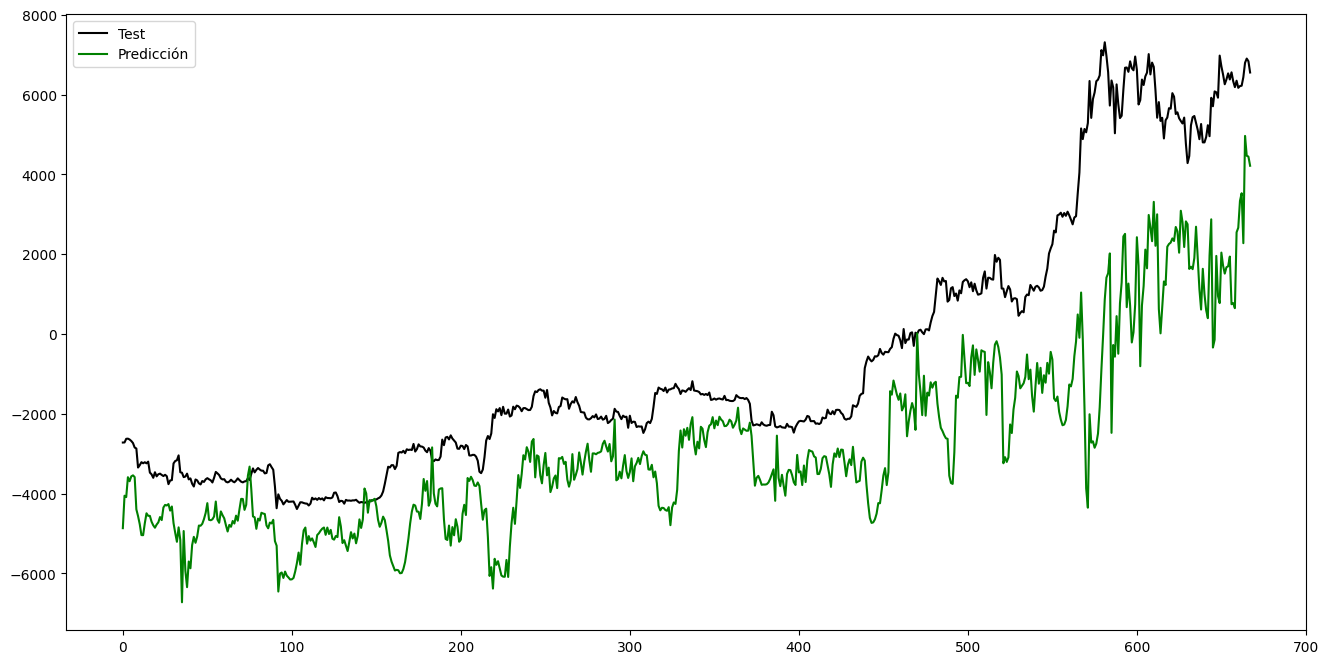

In [144]:
patch_mixer_model.eval()
with torch.no_grad():
    patch_mixer_y_pred = patch_mixer_model(X_test_torch).numpy()

# Reshape predictions and test data
target_index = -1
patch_mixer_y_pred = patch_mixer_y_pred[:,:,target_index] #Extract only the predictions for the target feature.
patch_mixer_y_pred = patch_mixer_y_pred.reshape(patch_mixer_y_pred.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

# Inverse transform the predictions
scaler_onedimension = MinMaxScaler(feature_range=(0, 1))
scaler_onedimension.fit(data["Target"].values.reshape(-1, 1))

patch_mixer_y_pred_not_scaled = scaler_onedimension.inverse_transform(patch_mixer_y_pred)
y_test_not_scaled = scaler_onedimension.inverse_transform(y_test)

# Print predictions and real values
for i in range(10):
    print(f'Predicción: {patch_mixer_y_pred_not_scaled[i]}, Valor real: {y_test_not_scaled[i]}')

# Plot predictions vs actual values
plt.figure(figsize=(16, 8))
plt.plot(y_test_not_scaled, color='black', label='Test')
plt.plot(patch_mixer_y_pred_not_scaled, color='green', label='Predicción')
plt.legend()
plt.show()


In [145]:
if len(patch_mixer_y_pred.shape) > 1 and patch_mixer_y_pred.shape[1] == 1:
    patch_mixer_y_pred = patch_mixer_y_pred.flatten()
patch_mixer_metrics = calculate_metrics(y_test, patch_mixer_y_pred)
print(patch_mixer_metrics[0])
print(patch_mixer_metrics[1])
print(patch_mixer_metrics[2])

0.032822024353182225
0.14413296852712199
0.30065334870043
